In [73]:
import os
import os.path as path
from tqdm import tqdm

import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as la

from src.structured_random_features.src.models.weights import V1_weights

# Packages for fft and fitting data
from scipy import fftpack as fft
from sklearn.linear_model import Lasso

# Package for importing image representation
from PIL import Image, ImageOps

# Package for storing reformed image
import imageio

In [74]:
def generateY(W, img):
    n, m = img.shape
    y = W @ img.reshape(n * m, 1)
    return y

In [75]:
def generateV1Variables(numCell, cellSize, sparseFreq, img):
    # Get size of image
    dim = np.asanyarray(img).shape
    n, m = dim
    # Store generated V1 cells in W
    W = V1_weights(numCell, dim, cellSize, sparseFreq) 
    
    # Retrieve y from W @ imgArr
    y = W @ img.reshape(n*m, 1)

    # Resize W to shape (numCell, height of image, width of image) for fetching into function
    W = W.reshape(numCell, dim[0], dim[1])
    return W, y

In [76]:

# Function: compress
# Parameters:
##     W: An opened index for measurement
##     y: the value of the opened index W
##     alpha: panelty value to fit for Lasso
##     dim (n, m): image size that needs to be reformed

# Return:
##     theta: matrix of W when FFT took in place
##     reformed: Reformed image in array
##     s: sparse vector s which is a estimated coefficient generated from LASSO
def compress(W, y, alpha):
    sampleSz, n, m = W.shape
    
    ## WΨ
    theta = fft.dctn(W.reshape(sampleSz, n, m), norm = 'ortho', axes = [1, 2])
    theta = theta.reshape(sampleSz, n * m)

    ## Initialize Lasso and Fit data
    mini = Lasso(alpha = alpha)
    mini.fit(theta, y)
    
    ## Retrieve sparse vector s
    s = mini.coef_
    
    # Reform the image using sparse vector s with inverse descrete cosine
    reform = fft.idctn(s.reshape(n, m), norm='ortho', axes=[0,1])
    
    #return theta, reformed img, sparse vectors
    return theta, reform, s

Lossy conversion from float64 to uint8. Range [49.354303270485644, 226.00904801698843]. Convert image to uint8 prior to saving to suppress this warning.


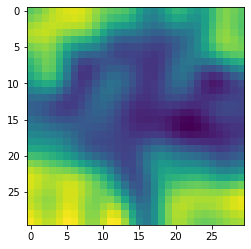

In [77]:
## Changing V1 weight for each time

# took 30 X 30 pixel part of tree image at about coord(650, 260)
inputImg = "image/tree_part1.jpg"
img = Image.open(inputImg)
img = ImageOps.grayscale(img)
imgArr = np.asarray(img)

numCell = 100   # for randomizing numCell: np.random.randint(50, 2000)

cellSize = 2 #For randomizing cellSize: np.random.uniform(0.01, 20)
sparseFreq = 2 #For randomizing freq: np.random.randint(1, 10)

W, y = generateV1Variables(numCell, cellSize, sparseFreq, imgArr)

## Return reform image array
theta, reform, s = compress(W, y, 90)


imageio.imwrite('reformedImage.jpeg', reform)

plt.imshow(reform)

In [83]:
## Making V1 weight to be consistent

img = Image.open("image/tree_part1.jpg")
img = ImageOps.grayscale(img)
imgArr = np.asarray(img)

# V1 Variables
numCell = 100
cellSize = 2
sparseFreq = 2
dim = imgArr.shape
n,m = dim

W = V1_weights(numCell, dim, cellSize, sparseFreq) 
y = generateY(W, imgArr)
W_rev = W.reshape(numCell, n, m)
theta, reform, s = compress(W_rev, y, 50)


30 30


/home/bans/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 68.64204745047238, tolerance: 56.04013111111111
  model = cd_fast.enet_coordinate_descent(


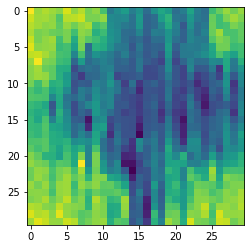

In [69]:
## Check if this function is applicable to regular compress sensing
compressImg = Image.open("image/tree_part1.jpg")
compressImg = ImageOps.grayscale(compressImg)
compressArr = np.asarray(compressImg)
cn, cm = compressArr.shape
print(cn, cm)
compressSamp = np.floor (cn * cm * 0.20).astype(int)
randIndex = np.random.randint(0, cn * cm, compressSamp)
compressY = compressArr.flatten()[randIndex]
compressY = compressY.reshape(compressSamp, 1)

# Generate C matrix
C = np.eye(cn * cm)[randIndex, :]
C3D = C.reshape(compressSamp, cn, cm)
theta, reform, s = compress(C3D, compressY, 0.00005)

plt.imshow(reform)